In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/mias-mammography/Info.txt
/kaggle/input/mias-mammography/all_mias_scans.h5
/kaggle/input/mias-mammography/all-mias.tar.gz
/kaggle/input/mias-mammography/all-mias/mdb152.pgm
/kaggle/input/mias-mammography/all-mias/mdb088.pgm
/kaggle/input/mias-mammography/all-mias/mdb113.pgm
/kaggle/input/mias-mammography/all-mias/mdb182.pgm
/kaggle/input/mias-mammography/all-mias/mdb239.pgm
/kaggle/input/mias-mammography/all-mias/mdb066.pgm
/kaggle/input/mias-mammography/all-mias/mdb220.pgm
/kaggle/input/mias-mammography/all-mias/mdb292.pgm
/kaggle/input/mias-mammography/all-mias/mdb286.pgm
/kaggle/input/mias-mammography/all-mias/mdb103.pgm
/kaggle/input/mias-mammography/all-mias/mdb194.pgm
/kaggle/input/mias-mammography/all-mias/mdb275.pgm
/kaggle/input/mias-mammography/all-mias/mdb060.pgm
/kaggle/input/mias-mammography/all-mias/mdb067.pgm
/kaggle/input/mias-mammography/all-mias/mdb023.pgm
/kaggle/input/mias-mammography/all-mias/mdb073.pgm
/kaggle/input/mias-mammography/all-mias/mdb307.p

**The dataset used here is composed of images from the MIAS Mammography dataset**

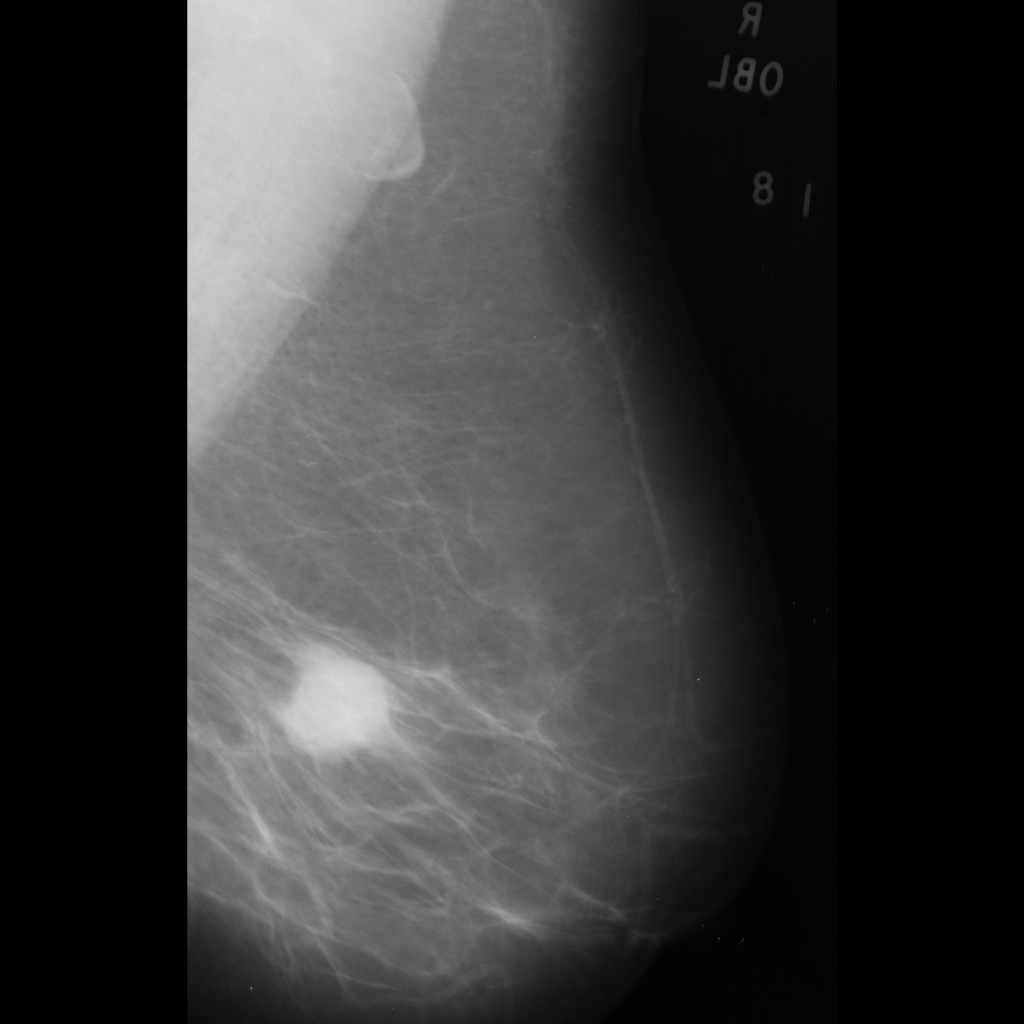

In [2]:
from PIL import Image
im = Image.open("../input/mias-mammography/all-mias/mdb028.pgm")
im

**Importing all the necessary packages.**

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output
from tqdm.notebook import tqdm
import cv2
from sklearn.model_selection import train_test_split
import random

In [4]:
imgs_path = '../input/mias-mammography/all-mias/' #assigning the image path value to imgs_path

**Reading the dataframe**

In [5]:
info=pd.read_csv("../input/mias-mammography/Info.txt",sep=" ")
info=info.drop('Unnamed: 7',axis=1)

In [6]:
info

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,mdb003,D,NORM,NaN,NaN,NaN,NaN
3,mdb004,D,NORM,NaN,NaN,NaN,NaN
4,mdb005,F,CIRC,B,477.0,133.0,30.0
...,...,...,...,...,...,...,...
325,mdb318,D,NORM,NaN,NaN,NaN,NaN
326,mdb319,D,NORM,NaN,NaN,NaN,NaN
327,mdb320,D,NORM,NaN,NaN,NaN,NaN
328,mdb321,D,NORM,NaN,NaN,NaN,NaN


In [7]:
ids = {}
for i in range(len(info)):
    ids[i] = info.REFNUM[i]

In [8]:
# Turning our outputs Normal-Abnormal to 0-1
label = []
for i in range(len(info)):
    if info.CLASS[i] != 'NORM':
        label.append(1)
    else:
        label.append(0)
label = np.array(label)
print(f"Total Images: {len(label)}\nNormales: {len(label)-np.sum(label)}\nNo normales: {np.sum(label)}")

Total Images: 330
Normales: 207
No normales: 123


In [9]:
# define the every images filepaths in to list
img_name = []

for i in range(len(label)):
        img_name.append(imgs_path + info.REFNUM[i]+ '.pgm')

In [10]:
count = 0
remove = True
temp_label = []
temp_img_name = []

for i, lbl in enumerate(label.tolist()):
    if lbl == 0 and remove == True:
        count = count + 1
        if count >= 84:
            remove = False
    else:
        temp_label.append(lbl)
        temp_img_name.append(img_name[i])
label = np.array(temp_label)
img_name = temp_img_name

In [11]:
img_name = np.array(img_name)
img_name.shape

(246,)

In [12]:
print(img_name)
print(f'image address amount {img_name.shape}')

['../input/mias-mammography/all-mias/mdb001.pgm'
 '../input/mias-mammography/all-mias/mdb002.pgm'
 '../input/mias-mammography/all-mias/mdb005.pgm'
 '../input/mias-mammography/all-mias/mdb005.pgm'
 '../input/mias-mammography/all-mias/mdb010.pgm'
 '../input/mias-mammography/all-mias/mdb012.pgm'
 '../input/mias-mammography/all-mias/mdb013.pgm'
 '../input/mias-mammography/all-mias/mdb015.pgm'
 '../input/mias-mammography/all-mias/mdb017.pgm'
 '../input/mias-mammography/all-mias/mdb019.pgm'
 '../input/mias-mammography/all-mias/mdb021.pgm'
 '../input/mias-mammography/all-mias/mdb023.pgm'
 '../input/mias-mammography/all-mias/mdb025.pgm'
 '../input/mias-mammography/all-mias/mdb028.pgm'
 '../input/mias-mammography/all-mias/mdb030.pgm'
 '../input/mias-mammography/all-mias/mdb032.pgm'
 '../input/mias-mammography/all-mias/mdb058.pgm'
 '../input/mias-mammography/all-mias/mdb059.pgm'
 '../input/mias-mammography/all-mias/mdb063.pgm'
 '../input/mias-mammography/all-mias/mdb069.pgm'
 '../input/mias-mamm

**Some random images for visualization**

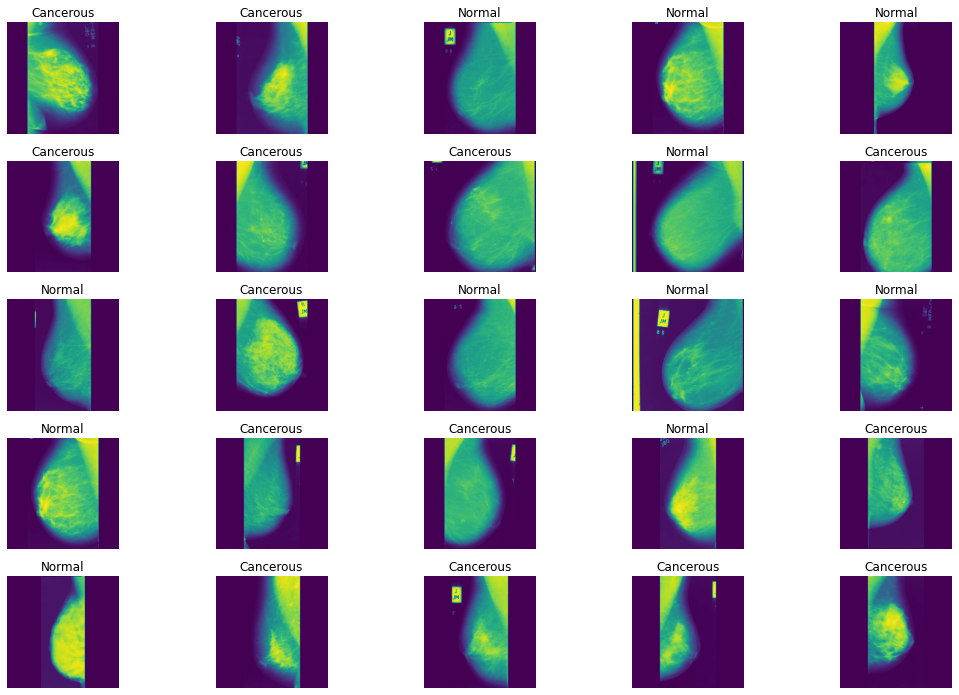

In [13]:
# view image random images
def view_25_random_image():
    fig = plt.figure(figsize = (15, 10))
    for i in range(25):
        rand = random.randint(0,len(label))
        ax = plt.subplot(5, 5, i+1)
    
        img = cv2.imread(img_name[rand], 0)
        img = cv2.resize(img, (256,256))
        if label[rand] == 1:
            plt.title('Cancerous')
        else:
            plt.title('Normal')
        plt.tight_layout()
        plt.axis('off')
        plt.imshow(img)
    fig.savefig('random_25_image_fig.png')

random_images = view_25_random_image()

In [14]:
img_path = []
last_label = []
IMG_SIZE = 128

for i in range(len(img_name)):
    
    img = cv2.imread(img_name[i], 0)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    rows, cols= img.shape
    for angle in range(180):
            M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle*2, 1)    #Rotate 0 degree
            img_rotated = cv2.warpAffine(img, M, (IMG_SIZE, IMG_SIZE))
            img_path.append(img_rotated)
            if label[i] == 1:
                last_label.append(1)
            else:
                last_label.append(0)

In [15]:
img_path = np.array(img_path)
last_label = np.array(last_label)
img_path.shape

(44280, 128, 128)

In [16]:
img_path = img_path.reshape((-1,IMG_SIZE,IMG_SIZE,1))
img_path.shape

(44280, 128, 128, 1)

In [17]:
last_label.shape

(44280,)

In [18]:
# split train and test set
x_train, x_test, y_train, y_test = train_test_split(img_path, last_label, test_size = 0.2, random_state = 42)

In [19]:
len(x_train),len(x_test),len(y_train),len(y_test)

(35424, 8856, 35424, 8856)

In [20]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.activations import *
from keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from time import time

In [21]:
reg = tf.keras.regularizers.L2(l2=1e-5)
ini = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=None)


model = Sequential()
model.add(Conv2D(32,
                 kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer = ini,
                 input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(Conv2D(64,
                 kernel_size=(3,3),
                 kernel_initializer = ini,
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64, 
                 kernel_size=(3,3),
                 kernel_initializer = ini,
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Dense(64, 
                kernel_initializer = ini,
                activation='relu'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-3)

model.compile(optimizer=optimizer,
              loss= 'binary_crossentropy',
              metrics=['accuracy'])

2022-02-10 13:00:41.946408: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-10 13:00:42.052794: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-10 13:00:42.053531: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-10 13:00:42.054648: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 64)        0         
_________________________________________________________________
dense (Dense)                (None, 30, 30, 64)        4

In [23]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5 ,restore_best_weights=True, verbose=1)

check_point_filepath = './'

model_check_point = ModelCheckpoint(filepath =check_point_filepath, monitor='val_loss', verbose=1, save_best_only=True,
                                    save_weights_only=False, mode='auto', save_freq='epoch')

In [24]:
train = True
if train:
    epochs=100
    history = model.fit(x_train,
                 y_train,
                 validation_split=0.2,
                 epochs=epochs,
                 batch_size=128,
                 callbacks=[early_stop, model_check_point])
else:
    model = tf.keras.models.load_model('./')

2022-02-10 13:00:45.345644: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-02-10 13:00:46.729108: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


222/222 [==============================] - 24s 76ms/step - loss: 0.6934 - accuracy: 0.5109 - val_loss: 0.6907 - val_accuracy: 0.5330

Epoch 00001: val_loss improved from inf to 0.69074, saving model to ./


2022-02-10 13:01:10.064943: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/100
222/222 [==============================] - 16s 71ms/step - loss: 0.6857 - accuracy: 0.5434 - val_loss: 0.6791 - val_accuracy: 0.5612

Epoch 00002: val_loss improved from 0.69074 to 0.67914, saving model to ./
Epoch 3/100
222/222 [==============================] - 16s 71ms/step - loss: 0.6726 - accuracy: 0.5713 - val_loss: 0.6679 - val_accuracy: 0.5660

Epoch 00003: val_loss improved from 0.67914 to 0.66788, saving model to ./
Epoch 4/100
222/222 [==============================] - 16s 71ms/step - loss: 0.6537 - accuracy: 0.5979 - val_loss: 0.6387 - val_accuracy: 0.6095

Epoch 00004: val_loss improved from 0.66788 to 0.63867, saving model to ./
Epoch 5/100
222/222 [==============================] - 16s 71ms/step - loss: 0.6219 - accuracy: 0.6318 - val_loss: 0.6155 - val_accuracy: 0.6250

Epoch 00005: val_loss improved from 0.63867 to 0.61554, saving model to ./
Epoch 6/100
222/222 [==============================] - 16s 71ms/step - loss: 0.5928 - accuracy: 0.6614 - val_loss: 0

The results was: True       And the probability being: 1.0
Real value was: True
Test id: 2026


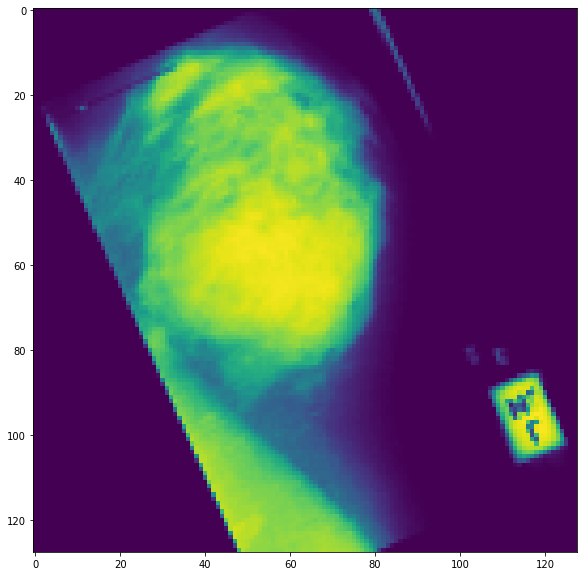

In [25]:
from random import randint
test_num = randint(0,len(x_test))
#test_num = 6948
result = model.predict(np.array([x_test[test_num]]))

plt.figure(figsize= (10,10))
plt.imshow(x_test[test_num])

print(f"The results was: {result[0][0]>= 0.5}       And the probability being: {result[0][0]}\nReal value was: {y_test[test_num]>=0.5}")
print(f"Test id: {test_num}")

In [26]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

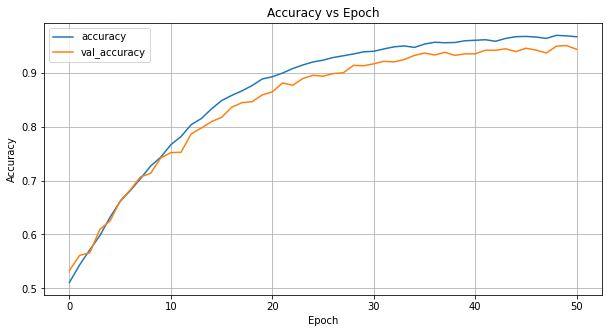

In [27]:
plt.figure(figsize=(10,5))
plt.plot(range(len(history.history['accuracy'])),history.history['accuracy'], label= "accuracy")
plt.plot(range(0,len(history.history['val_accuracy'])),history.history['val_accuracy'], label= "val_accuracy")
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()
plt.show()

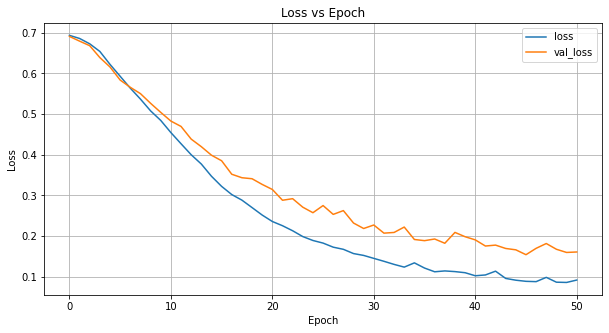

In [28]:
plt.figure(figsize=(10,5))
plt.plot(range(0,len(history.history['loss'])),history.history['loss'], label= "loss")
plt.plot(range(0,len(history.history['val_loss'])),history.history['val_loss'], label= "val_loss")
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.show()

In [29]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

277/277 - 2s - loss: 0.1456 - accuracy: 0.9514

Test accuracy: 0.9514453411102295


In [30]:
len(x_test)

8856

In [31]:
y_pred=model.predict(x_test)

In [32]:
y_pred.shape

(8856, 1)

In [33]:
len(last_label)

44280

In [34]:
y_test

array([1, 1, 1, ..., 0, 1, 0])

In [35]:
y_pred

array([[8.1011486e-01],
       [6.9329202e-01],
       [1.0000000e+00],
       ...,
       [1.5930150e-04],
       [9.9999976e-01],
       [4.9802504e-02]], dtype=float32)

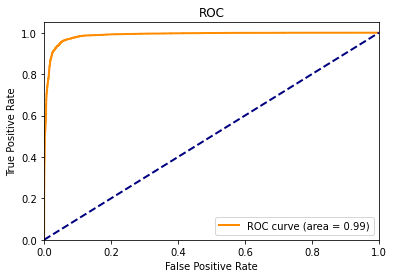

In [36]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#roc plot for specific class
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [37]:
from sklearn.metrics import roc_auc_score
pred_prob = model.predict(x_test)
#auc scores
auc_score = roc_auc_score(y_test, pred_prob)
print(auc_score)

0.9873818311466931


In [38]:
save_model = True
if save_model:
    save_model_path = "./Prakhar Alok Chaudhary_save/"
    model.save("pretrained_model.h5")